# 3 Sampling the Imaginary

First off, import libraries

In [1]:
:load ../src/Sampling
import Graphics.Gnuplot.Plot.TwoDimensional as Plot
import IHaskell.Display
import IHaskell.Display.Gnuplot
import Graphics.Gnuplot.Graph.TwoDimensional
import Graphics.Gnuplot.Simple
import Data.Bifunctor
import System.Random

Probability of 6 water out of 9 tosses of the globe, with water to earth ratio as 0.5

In [2]:
binomial 6 9 0.5

0.1640625

We want to estimate the water to earth ratio from the observation.  That is out parameter.  We use grid approxaimtion to find the posterior distribution of the parameter given our observation, 6 water out of 9 tosses.

Computing the posterior requires multiplying the likelihood of observation given different parameter values, and their priors.  Priors can be just counts.  So we first use the the "flat prior", which is the same count for all parameter values, say 0.1.

We will study how different priors affect the posterior.  But first we will solve a simple question: does it matter that we use prior *counts* versus *probabilities*?  We know that probabilities are just normalized counts that sum to 1.  But when we multiply prior through the likelihood to find the posterior, does normalization on the prior matter?

We first compute the posterior with prior counts, and then with prior probabilities.

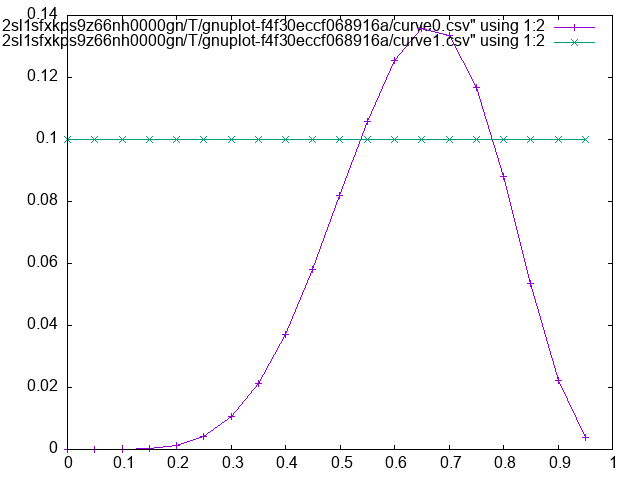

In [3]:
plot pGrid prior post = 
    let p1 = Plot.list linesPoints (zip pGrid post)
        p2 = Plot.list linesPoints (zip pGrid prior)
        in printDisplay $ p1 <> p2

let pGrid = grid 0 1 (1 / 20)
    prior = replicate (length pGrid) 0.1
    post  = standardize $ gridApproxPosterior pGrid prior (binomial 6 9)
    in plot pGrid prior post

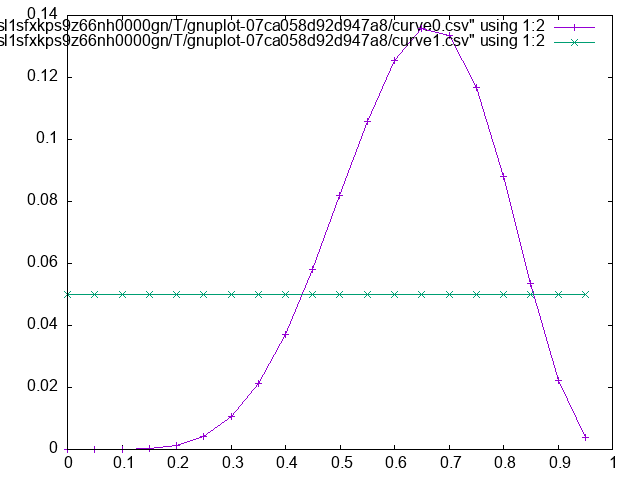

In [4]:
let pGrid = grid 0 1 (1 / 20)
    prior = standardize $ replicate (length pGrid) 0.1
    post = standardize $ gridApproxPosterior pGrid prior (binomial 6 9)
    in plot pGrid prior post

As we can see, the two posteriors are the same under either prior counts or prior probabilities.  
The reason why this happens is to use the garden of forking paths again, and since prior counts are multiplied with the corresponding likelihoods, and then normalized to posterior probabilities, so it doens't matter if we normalize the prior or not, because the normalization of the posterior takes care of that.

Next we look at a few different priors and the corresponding posteriors.
* certainty in prior: non-existent (prior=0)
* 

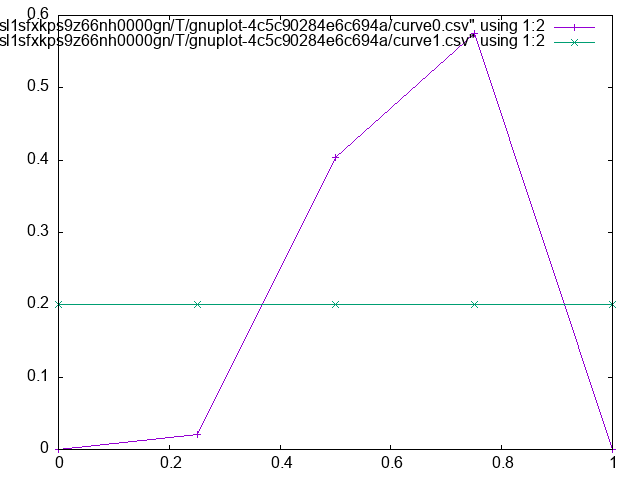

In [5]:
let pGrid = grid 0 1 (1 / 4)
    prior = replicate (length pGrid) 0.1
    post  = standardize $ gridApproxPosterior pGrid prior (binomial 6 9)
    in plot pGrid (standardize prior) post

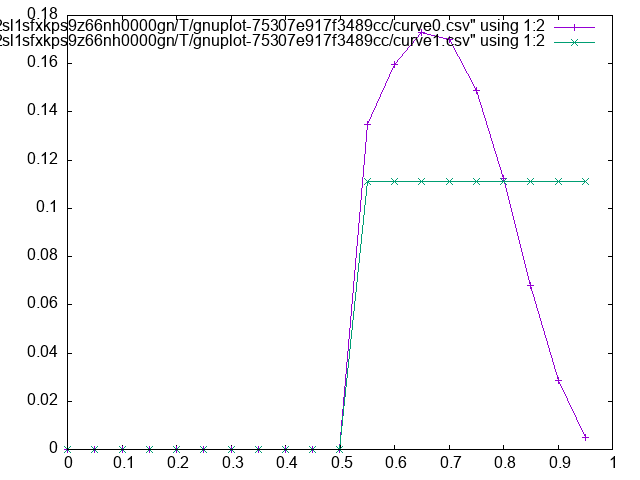

In [6]:
let pGrid = grid 0 1 (1 / 20)
    prior = map (\(x, y) -> if x < 0.5 then 0 else y) . zip pGrid $ replicate (length pGrid) 0.1
    post = standardize $ gridApproxPosterior pGrid prior (binomial 6 9)
    in plot pGrid (standardize prior) post

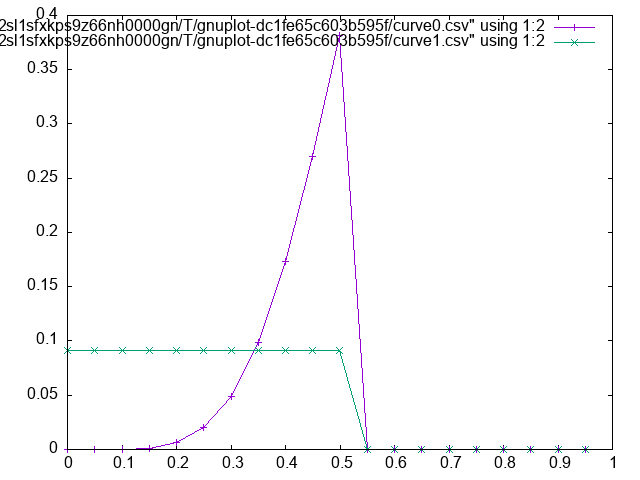

In [7]:
let pGrid = grid 0 1 (1 / 20)
    prior = map (\(x, y) -> if x > 0.5 then 0 else y) . zip pGrid $ replicate (length pGrid) 0.1
    post = standardize $ gridApproxPosterior pGrid prior (binomial 6 9)
    in plot pGrid (standardize prior) post

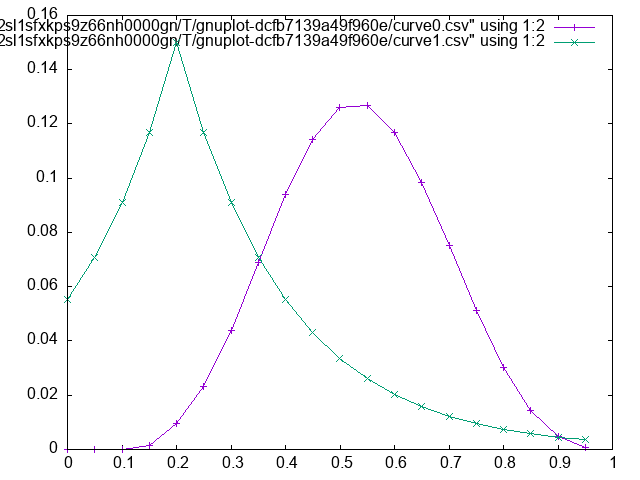

In [8]:
let pGrid = grid 0 1 (1 / 20)
    prior = map (\x -> exp . negate . abs $ 5 * (x - 0.2)) pGrid
    post = standardize $ gridApproxPosterior pGrid prior (binomial 6 9)
    in plot pGrid (standardize prior) post

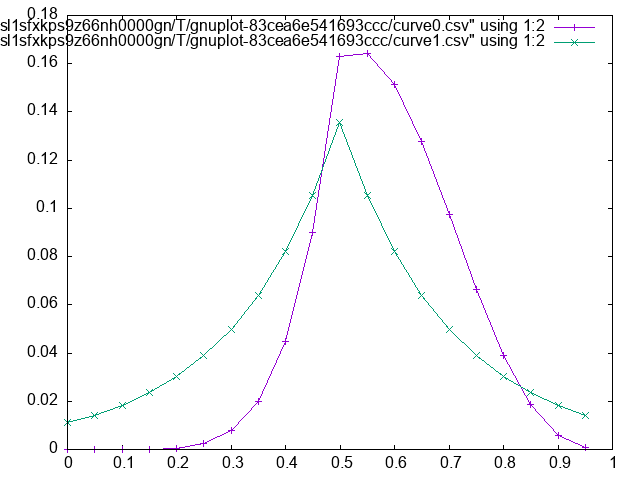

In [9]:
let pGrid = grid 0 1 (1 / 20)
    prior = map (\x -> exp . negate . abs $ 5 * (x - 0.5)) pGrid
    post = standardize $ gridApproxPosterior pGrid prior (binomial 6 9)
    in plot pGrid (standardize prior) post

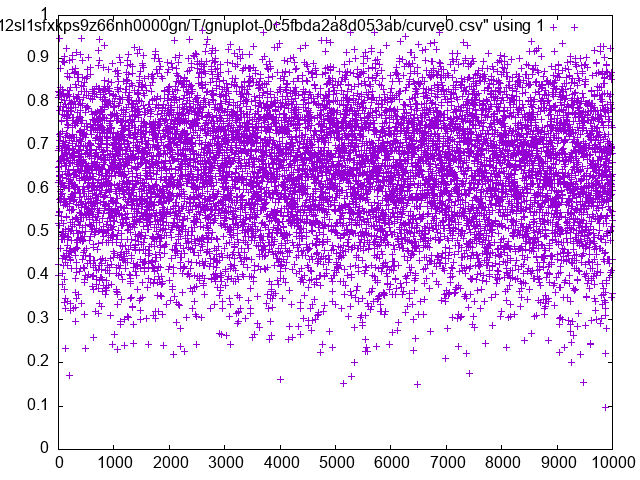

In [10]:
(pGrid, post) = 
    let pGrid = grid 0 1 (1 / 1000)
        prior = replicate (length pGrid) 1.0
        like = map (binomial 6 9) pGrid
        postCount = zipWith (*) like prior
        post = map (/ sum postCount) postCount
        in (pGrid, post)

pSample = 
    let size = 10000
        rng = mkStdGen seed
        seed = 1
    in sampleDiscrete rng pGrid post size
    
printDisplay $ Plot.list listPoints pSample

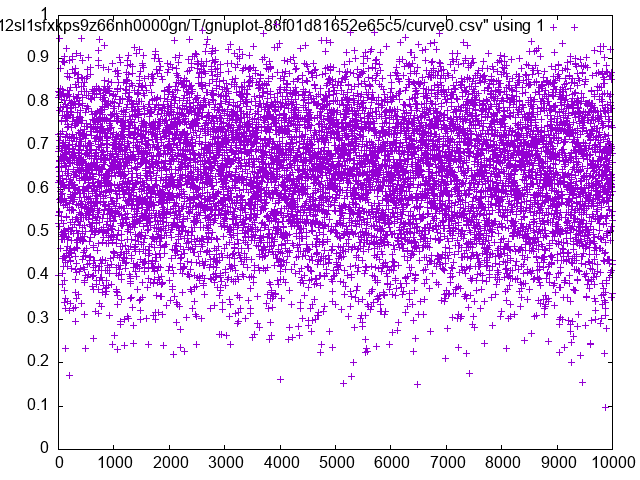

In [11]:
pSample = 
    let size = 10000
        rng = mkStdGen seed
        seed = 1
    in sampleContinuum rng pGrid post size

printDisplay $ Plot.list listPoints pSample

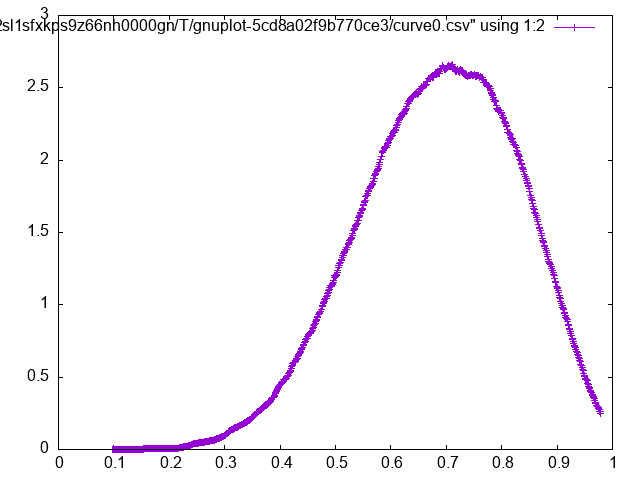

In [12]:
pSample = 
    let size = 10000
        rng = mkStdGen seed
        seed = 1
    in sampleDiscrete rng pGrid post size

(Dens _ pdf) = discreteKDE pSample 1e-1 1e-3

printDisplay $ Plot.list linesPoints pdf

## Summarize the posterior
- Posterior mass by an interval
- Interval by posterior mass ("quantile", "confidence interval", "credible interval")
- Highest posterior density interval (HPDI)
- Point estimates
    - Loss function

### Posterior mass by an interval

In [13]:
sum . map snd . takeWhile ((< 0.5) . fst) $ zip pGrid post

0.1710555078121782

In [14]:
massByInterval (0, 0.5) pSample

0.1722

In [15]:
massByInterval (0.5, 0.75) pSample

0.5974

### Interval by posterior mass

In [16]:
intervalByMass (0, 0.8) pSample

(9.700000000000007e-2,0.7620000000000006)

In [17]:
-- 80 percentile
intervalByMass (0.1, 0.9) pSample

(0.44600000000000034,0.8140000000000006)

### Highest posterior density interval

In [18]:
(pGrid, post) = 
    let pGrid = grid 0 1 (1 / 1000)
        prior = replicate (length pGrid) 1.0
        like = map (binomial 3 3) pGrid
        postCount = zipWith (*) like prior
        post = map (/ sum postCount) postCount
        in (pGrid, post)

pSample = 
    let size = 10000
        rng = mkStdGen seed
        seed = 1
    in sampleDiscrete rng pGrid post size

In [19]:
-- 50 percentile
intervalByMass (0.25, 0.75) pSample

(0.7050000000000005,0.9320000000000007)

In [20]:
hpdi 0.5 pSample

(0.8400000000000006,0.9990000000000008)

### Point estimates

In [21]:
pdf = discreteKDE pSample 1e-1 1e-3
mode pdf

0.9990000000000008

In [22]:
mean pdf

0.807445654309067

In [23]:
median pSample

0.8400000000000006

#### Loss function

In [24]:
lossAbsDist post pGrid 0.5

0.31212468724981307

In [25]:
let f = lossAbsDist post pGrid in firstBy (\x x' -> f x < f x') pGrid

0.8400000000000006

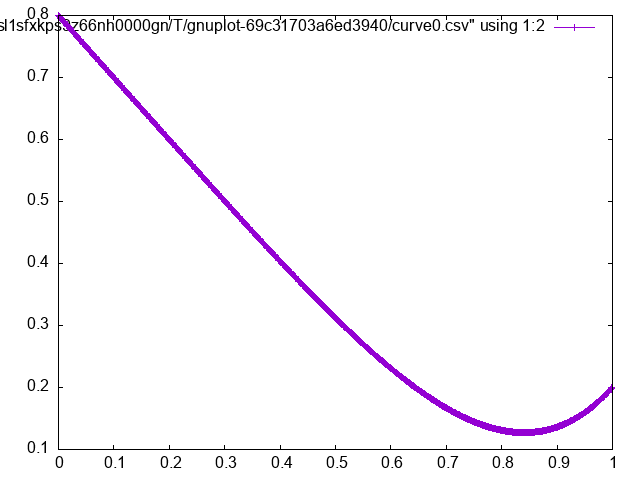

In [26]:
printDisplay . Plot.list linesPoints . zip pGrid $ map (lossAbsDist post pGrid) pGrid

In [27]:
lossSqrDist post pGrid 0.5

0.11639993346680057

In [28]:
let f = lossSqrDist post pGrid in firstBy (\x x' -> f x < f x') pGrid

0.8000000000000006

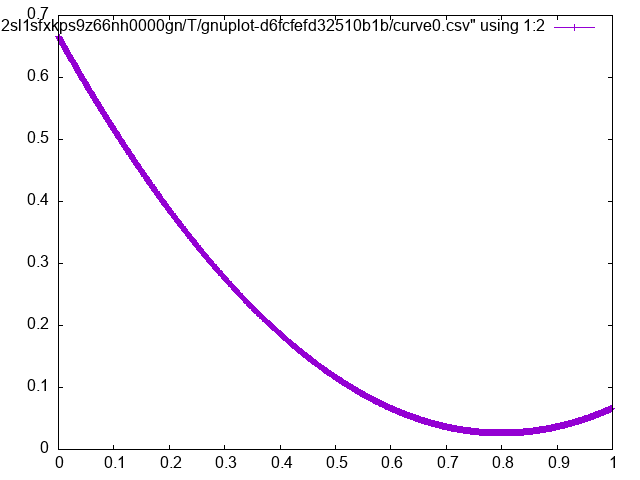

In [29]:
printDisplay . Plot.list linesPoints . zip pGrid $ map (lossSqrDist post pGrid) pGrid

## Simulate prediction

In [30]:
rng = mkStdGen 1

In [31]:
map (\x -> binomial x 2 0.7) [0..2]

[9.000000000000002e-2,0.42000000000000004,0.48999999999999994]

In [32]:
rbinom rng 1 2 0.7

[0]

In [33]:
rbinom rng 10 2 0.7

[0,2,2,1,2,0,2,2,1,1]

In [34]:
let cs = table $ rbinom rng (floor 1e5) 2 0.7
    s = fromIntegral . sum $ map snd cs
    in map (second ((/ fromIntegral s).fromIntegral)) cs

[(0,9.028e-2),(1,0.41741),(2,0.49231)]

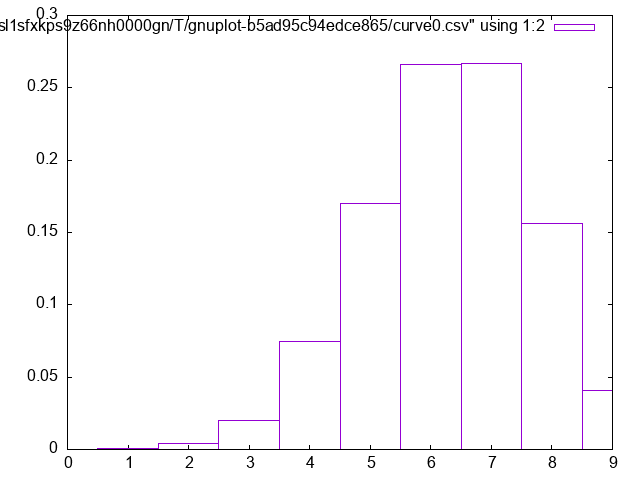

In [35]:
let cs = table $ rbinom rng (floor 1e5) 9 0.7
    s = fromIntegral . sum $ map snd cs
    pmf = map (second ((/s).fromIntegral)) cs
    in printDisplay $ Plot.list boxes pmf

In [36]:
pSample = 
    let pGrid = grid 0 1 (1 / 1000)
        prior = replicate (length pGrid) 1.0
        like = map (binomial 6 9) pGrid
        postCount = zipWith (*) like prior
        post = map (/ sum postCount) postCount
        in sampleDiscrete rng pGrid post 10000
xObs = 
    let predF rng = head . rbinom rng 1 9
    in simulate rng (floor 10000) pSample predF

table xObs

[(1,6),(2,102),(3,543),(4,1481),(5,2425),(6,2658),(7,2106),(8,668),(9,11)]

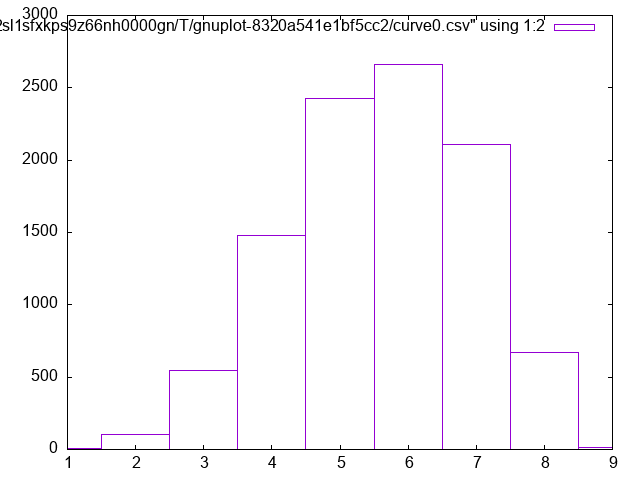

In [37]:
printDisplay $ Plot.list boxes (table xObs)